In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
test = pd.read_csv('data/test.csv.gz')

X_train = pd.DataFrame(np.load('data/X_train.npz')['X_train'])
X_val = pd.DataFrame(np.load('data/X_val.npz')['X_val'])
y_train = pd.DataFrame(np.load('data/y_train.npz')['y_train'])
y_val = pd.DataFrame(np.load('data/y_val.npz')['y_val'])
test_new = pd.DataFrame(np.load('data/test_new.npz')['test_new'])

In [94]:
def rmse(*args):
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))
def clip20(x):
    return np.clip(x, 0, 20)

Now that the model is trained and saved for later usage, what's left is simply submitting.

So, here I train the stacking model. Also I check how correlated are the predictions for the first level models (because this matters in stacking).

## Stacking

- **First Level models (Base models):** Light Gradient Boosting, XGBoost, Random Forest. These are used to build the 2-nd level **train-metafetures**.
- **Second Level models (Meta-model):** Linear Regression

### First level models

In [95]:
lgb_model = pickle.load(open('models/best_lgb.sav', 'rb'))
xgb_model = pickle.load(open('models/best_xgb.sav', 'rb'))
rf_model = pickle.load(open('models/best_rf.sav', 'rb'))

I noticed that perfection in these metrics indicate obvious OVERFITTING. So 0.6 or even higher might be excellent for submission.

In [96]:
pred_lgb_val = lgb_model.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb_model.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.803421
Val RMSE for lgb is 0.708723


In [97]:
pred_xgb_val = xgb_model.predict(X_val)
print('Train RMSE for xgb is %f' % rmse(clip20(y_train), clip20(xgb_model.predict(X_train))))
print('Val RMSE for xgb is %f' % rmse(clip20(y_val), clip20(pred_xgb_val)))

Train RMSE for xgb is 0.858557
Val RMSE for xgb is 0.776249


In [98]:
pred_rf_val = rf_model.predict(X_val)
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf_model.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), clip20(pred_rf_val)))

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


Train RMSE for rf is 0.821884
Val RMSE for rf is 0.707326


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished


### Correlation

This is for checking how correlated are the preditions by the base models.

It is understandable that models have to be as different as possible.

/Users/rgap/.virtualenvs/rgap-lectures/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
/Users/rgap/.virtualenvs/rgap-lectures/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


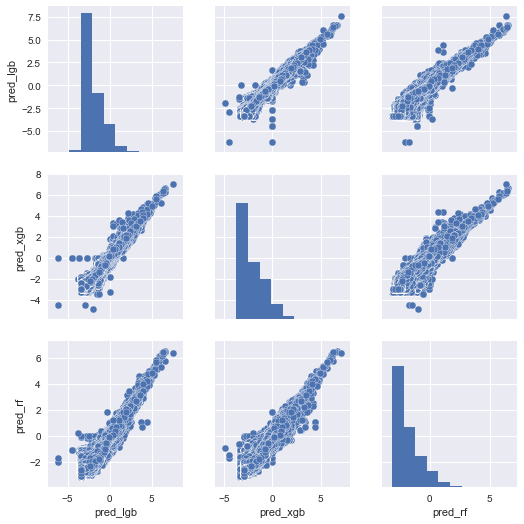

In [138]:
sns.pairplot(pd.DataFrame({'pred_lgb':np.nan_to_num(np.log(pred_lgb_val)),
                           'pred_xgb':np.nan_to_num(np.log(pred_xgb_val)),
                           'pred_rf':np.nan_to_num(np.log(pred_rf_val))}))

### Second level model

In [147]:
X_val_level2 = np.c_[pred_lgb_val, pred_xgb_val, pred_rf_val] 

In [148]:
lr = LinearRegression()
lr.fit(X_val_level2, y_val)

# This is the stacking part
pred_lr_val =  clip20(lr.predict(X_val_level2))

print('Test rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

Test rmse for stacking variables is 0.706040


## Submission

We apply the same logic to the test data

In [149]:
pred_test_lgb = lgb_model.predict(test_new)
pred_test_xgb = xgb_model.predict(test_new)
pred_test_rf = rf_model.predict(test_new)
X_test_level2 = np.c_[pred_test_lgb, pred_test_xgb, pred_test_rf]
test_pred = clip20(lr.predict(X_test_level2))
test_pred.mean()

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished


0.18041689966474664

In [150]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left')
submision[['ID', 'item_cnt_month']].to_csv('submission/submission.csv',index=False)